This notebook will track our progress using different unsupervised and supervised learning techniques to train our model to detect political bias in text.

In [ ]:
# All generic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse

In [ ]:
df = pd.read_parquet("hf://datasets/lelouch0204/cleaned_allsides_v2.csv/data/train-00000-of-00001.parquet")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print(df.columns)
print(df.iloc[1]['Text'])
print(df.iloc[1]['Bias'])

df = df[["Text", "Bias"]]

Index(['Title', 'Link', 'Text', 'Source', 'Bias', 'text_length', 'clean_text',
       'lemmatized', 'keywords', 'cluster', '__index_level_0__'],
      dtype='object')
From a multimillion-dollar law firm payout to six-figure endorsements and book deals, President Donald Trumpâ€™s nominee for health and human services secretary, Robert F. Kennedy Jr., raked in at least $12 million in total income in the past two years, new personal financial disclosure forms show. Kennedy boasted a vast amount of wealth across various investment funds, bank accounts and real estate properties totaling between $8.6 million to $33.4 million. However, he also reported a staggering amount of liabilities -- between $3.4 million and $12.7 million -- which could put him in the red on paper. Kennedy's liabilities include up to $1.2 million in credit card debt to American Express at a 23% revolving interest rate and three 30-year mortgages worth up to $10.5 million, according to the filing. The exact values of hi

In [ ]:
print("Labels: ", pd.unique(df['Bias']))

print(df.groupby(['Bias']).count())


Labels:  ['lean left' 'left' 'right' 'center' 'lean right']
            Text
Bias            
center       644
lean left    776
lean right   549
left        2967
right       1273


In [ ]:
label_map = {
    "center": 2,
    "lean left": 1,
    "lean right": 3,
    "left": 0,
    "right": 4,
}

In [ ]:
df['Label'] = df['Bias'].map(label_map)
df = df[["Text", "Label"]]

In [ ]:
print("Labels: ", pd.unique(df['Label']))

print(df.groupby(['Label']).count())

Labels:  [1 0 4 2 3]
       Text
Label      
0      2967
1       776
2       644
3       549
4      1273


Labels: integers 0 - 4.

0 = “highly conservative”

1 = “moderately conservative”

2 = “centrist / balanced”

3 = “moderately liberal”

4 = “highly liberal”

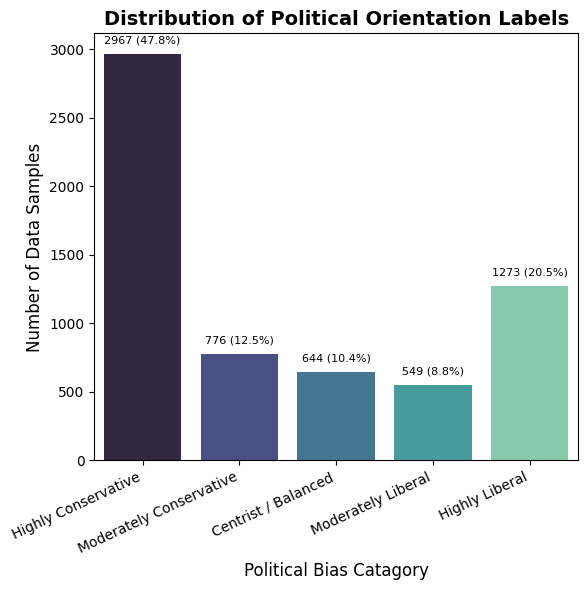

In [ ]:
label_map = {
    0: "Highly Conservative",
    1: "Moderately Conservative",
    2: "Centrist / Balanced",
    3: "Moderately Liberal",
    4: "Highly Liberal"
}

label_counts = df.groupby('Label')['Text'].count().reset_index()
label_counts.columns = ['Label', 'Count']

label_counts['Category'] = label_counts['Label'].map(label_map).fillna(label_counts['Label'].astype(str))

plt.figure(figsize = (6, 6))
sns.barplot(data=label_counts, x='Category', y='Count', hue = 'Category', palette='mako')
total = label_counts['Count'].sum()
for i, row in label_counts.iterrows():
    plt.text(i, row['Count'] + total * 0.01, f"{row['Count']} ({row['Count']/total:.1%})", ha='center', va='bottom', fontsize=8)

plt.title("Distribution of Political Orientation Labels", fontsize=14, weight='bold')
plt.xlabel("Political Bias Catagory", fontsize=12)
plt.ylabel("Number of Data Samples", fontsize=12)
plt.xticks(rotation=25, ha='right')

plt.tight_layout()
plt.show()

# Some standard pre-processing
1. TF-IDF
2. Using a SentenceTransformer
3. Use BERT / DistilBERT CLS token embeddings

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
X = model.encode(df['Text'], convert_to_numpy=True, )

y = df['Label']

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# That's a lot of features?
X.shape

(6209, 384)

In [ ]:
y.shape

(6209,)

# Dimensionality reduction
We should probably still do some PCA, Forward/Backward Feature Selection, Random Forest Feature Selection techniques

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)  # reduce to 50 dims
X_pca = pca.fit_transform(X)

print("Original shape:", X.shape)
print("Reduced shape:", X_pca.shape)


Original shape: (6209, 384)
Reduced shape: (6209, 50)


# Unsupervised learning techniques
I'll experiment with the [Political Bias](https://huggingface.co/datasets/cajcodes/political-bias) dataset, but it should be easy to translate to our final dataset as well.

In [ ]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    fowlkes_mallows_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
)

metrics = {
    "Silhouette Score": lambda X, labels: silhouette_score(X, labels),
    "Calinski-Harabasz": lambda X, labels: calinski_harabasz_score(X, labels),
    "Davies-Bouldin": lambda X, labels: davies_bouldin_score(X, labels),
    "Adjusted Rand Index": adjusted_rand_score,
    "Fowlkes-Mallows": fowlkes_mallows_score,
    "NMI": normalized_mutual_info_score,
    "Homogeneity": homogeneity_score,
    "Completeness": completeness_score,
    "V-Measure": v_measure_score,
}

# A natural choice for number of clusters is number of unique labels
NUM_CLUSTERS = len(pd.unique(df['Label']))

# Use PCA or not
REDUCED_DIMENSION = True

In [ ]:
# K-means
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
mini_batch_kmeans = MiniBatchKMeans(n_clusters=NUM_CLUSTERS, random_state=42)

In [ ]:
#Fit K-means
kmeans_labels = kmeans.fit_predict(X)
mbk_labels = mini_batch_kmeans.fit_predict(X)
pca = PCA(n_components=2, random_state=42)
X_vis = pca.fit_transform(X)

In [ ]:
# GMM
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

gmm = GaussianMixture(n_components=NUM_CLUSTERS, random_state=42, covariance_type='full')
bayes_gmm = BayesianGaussianMixture(n_components=NUM_CLUSTERS, random_state=42, covariance_type='full')

#Fit GMMs
gmm_labels = gmm.fit_predict(X)
bayes_labels = bayes_gmm.fit_predict(X)
gmm_centers = gmm.means_
bayes_centers = bayes_gmm.means_

pca = PCA(n_components=2, random_state=42)
X_vis = pca.fit_transform(X)
gmm_centers_2d = pca.transform(gmm_centers)
based_centers_2d = pca.transform(bayes_centers)


In [ ]:
# Density based: DBScan + OPTICS + Mean Shift
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import MeanShift

dbscan = DBSCAN(eps=0.5, min_samples=5)
hdbscan = HDBSCAN(min_cluster_size=5, min_samples=5)
optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.1)
mean_shift = MeanShift()

In [ ]:
# Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch

agglomerative = AgglomerativeClustering(n_clusters=NUM_CLUSTERS)
birch = Birch(n_clusters=NUM_CLUSTERS)

In [ ]:
# Spectral Clustering
from sklearn.cluster import SpectralClustering

# Increased n_neighbors from default (which is often 10 or n_samples / 10)
spectral = SpectralClustering(n_clusters=NUM_CLUSTERS, affinity='nearest_neighbors', n_neighbors=50)

In [ ]:
# Kernel Density Estimation (KDE)
from sklearn.neighbors import KernelDensity

kde = KernelDensity(bandwidth=1.0)

In [ ]:
# if REDUCED_DIMENSION:
#     X = X_pca

labels = {
    "K-Means": kmeans.fit_predict(X),
    "Mini-Batch K-Means": mini_batch_kmeans.fit_predict(X),
    "GMM": gmm.fit_predict(X),
    "Bayes GMM": bayes_gmm.fit_predict(X),
    "DBSCAN": dbscan.fit_predict(X),
    "HDBSCAN": hdbscan.fit_predict(X),
    "OPTICS": optics.fit_predict(X),
    "Mean Shift": mean_shift.fit_predict(X),
    "Agglomerative": agglomerative.fit_predict(X),
    "Birch": birch.fit_predict(X),
    "Spectral": spectral.fit_predict(X),
    # "KDE": kde.fit_predict(X),
}

In [ ]:
pred_df = []
for name, label in labels.items():
    unique_labels = np.unique(label)
    n_clusters = len(unique_labels)

    for metric_name, metric_func in metrics.items():
        # Metrics that require ground truth labels
        if metric_name in ["Adjusted Rand Index", "Fowlkes-Mallows", "NMI", "Homogeneity", "Completeness", "V-Measure"]:
            score = metric_func(y, label)

        # Metrics that require more than one cluster
        elif metric_name in ["Silhouette Score", "Calinski-Harabasz", "Davies-Bouldin"]:
            if n_clusters > 1:
                score = metric_func(X, label)
            else:
                score = np.nan

        # Other metrics (if any) that don't have specific requirements
        else:
            score = metric_func(X, label)

        pred_df.append(
            {"Algorithm": name, "Metric": metric_name, "Score": score}
        )

pred_df = pd.DataFrame(pred_df)

In [ ]:
computed_metrics = pd.DataFrame(pred_df)

# Normalize metrics that are not already between 0 and 1
def normalize_metric(df, metric_name, reverse=False):
    metric_values = df[df['Metric'] == metric_name]['Score']
    min_val = metric_values.min()
    max_val = metric_values.max()
    if max_val == min_val:
        return pd.Series([0.5] * len(metric_values), index=metric_values.index) # Handle case where all values are the same
    if reverse:
        # For metrics where lower is better (like Davies-Bouldin), reverse the normalization
        return (max_val - metric_values) / (max_val - min_val)
    else:
        return (metric_values - min_val) / (max_val - min_val)

# Apply normalization
computed_metrics.loc[computed_metrics['Metric'] == 'Calinski-Harabasz', 'Score'] = normalize_metric(computed_metrics, 'Calinski-Harabasz')
computed_metrics.loc[computed_metrics['Metric'] == 'Davies-Bouldin', 'Score'] = normalize_metric(computed_metrics, 'Davies-Bouldin', reverse=True)

In [ ]:
computed_metrics

,Algorithm,Metric,Score
0,K-Means,Silhouette Score,0.022299
1,K-Means,Calinski-Harabasz,1.000000
2,K-Means,Davies-Bouldin,0.152012
3,K-Means,Adjusted Rand Index,0.013659
4,K-Means,Fowlkes-Mallows,0.264112
...,...,...,...
94,Spectral,Fowlkes-Mallows,0.358107
95,Spectral,NMI,0.007923
96,Spectral,Homogeneity,0.006984
97,Spectral,Completeness,0.009154


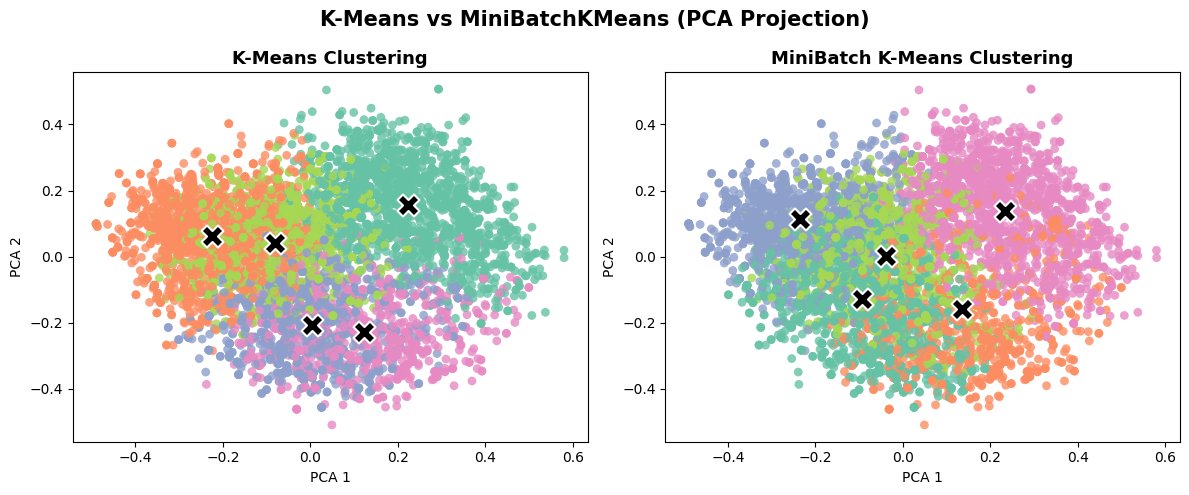

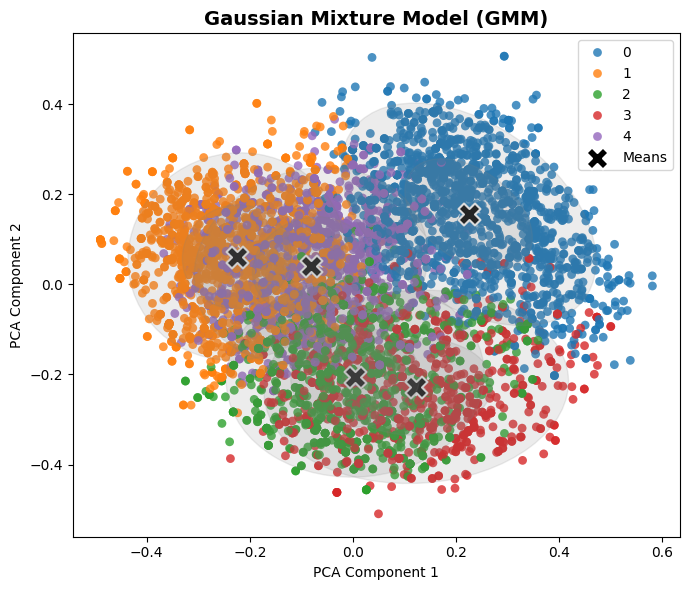

In [ ]:
#Metrics per Algorithm Visualization
# plt.figure(figsize=(10,6))
# sns.barplot(
#     data=computed_metrics,
#     x="Metric", y="Score",
#     hue="Algorithm",
#     palette="Set2"
# )

# plt.title("Comparison of Clustering Algorithms Across Metrics", fontsize=16, weight='bold')
# plt.xlabel("Metric", fontsize=12)
# plt.ylabel("Score", fontsize=12)
# plt.xticks(rotation=30, ha='right')
# plt.legend(title="Algorithm", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

def plot_clusters(X_vis, labels, centers=None, title="Cluster Visualization"):
    plt.figure(figsize=(6,5))
    sns.scatterplot(
        x=X_vis[:, 0], y=X_vis[:, 1],
        hue=labels, palette="tab10",
        s=40, alpha=0.8, edgecolor="none"
    )
    if centers is not None:
        plt.scatter(
            centers[:, 0], centers[:, 1],
            s=250, c='black', marker='X', edgecolor='white', linewidths=1.5, label='Centroids'
        )
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

#Visualize K-Means
kmeans_centers_2d = pca.transform(kmeans.cluster_centers_)
mbk_centers_2d = pca.transform(mini_batch_kmeans.cluster_centers_)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=X_vis[:,0], y=X_vis[:,1], hue=kmeans_labels, palette='Set2', s=40, alpha=0.8, edgecolor='none')
plt.scatter(kmeans_centers_2d[:,0], kmeans_centers_2d[:,1], s=250, c='black', marker='X', edgecolor='white', linewidths=1.5)
plt.title("K-Means Clustering", fontsize=13, weight='bold')
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.legend([],[], frameon=False)

plt.subplot(1,2,2)
sns.scatterplot(x=X_vis[:,0], y=X_vis[:,1], hue=mbk_labels, palette='Set2', s=40, alpha=0.8, edgecolor='none')
plt.scatter(mbk_centers_2d[:,0], mbk_centers_2d[:,1], s=250, c='black', marker='X', edgecolor='white', linewidths=1.5)
plt.title("MiniBatch K-Means Clustering", fontsize=13, weight='bold')
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.legend([],[], frameon=False)

plt.suptitle("K-Means vs MiniBatchKMeans (PCA Projection)", fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

#Visualize GMMs
def plot_gmm_clusters(X_vis, labels, centers_2d, covariances, title):
    plt.figure(figsize=(7,6))
    ax = plt.gca()
    sns.scatterplot(x=X_vis[:,0], y=X_vis[:,1], hue=labels, palette='tab10',
                    s=40, alpha=0.8, edgecolor='none')
    plt.scatter(centers_2d[:,0], centers_2d[:,1],
                s=250, c='black', marker='X', edgecolor='white', linewidths=1.5, label='Means')

    for mean, covar in zip(centers_2d, covariances):
        covar_2d = pca.components_ @ covar @ pca.components_.T
        draw_ellipse(mean, covar_2d, ax=ax, color='grey')

    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()

    if covariance.shape == (2, 2):
        U, s, _ = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle, width, height = 0, 0, 0

    for nsig in range(1, 3):
        ellipse = Ellipse(xy=position, width=nsig * width, height=nsig * height,angle=angle, alpha=0.15,**kwargs)
        ax.add_patch(ellipse)

plot_gmm_clusters(X_vis, gmm_labels, gmm_centers_2d, gmm.covariances_, "Gaussian Mixture Model (GMM)")
# plot_gmm_clusters(X_vis, bayes_labels, bayes_centers_2d, bayes_gmm.covariances_, "Bayesian Gaussian Mixture Model")


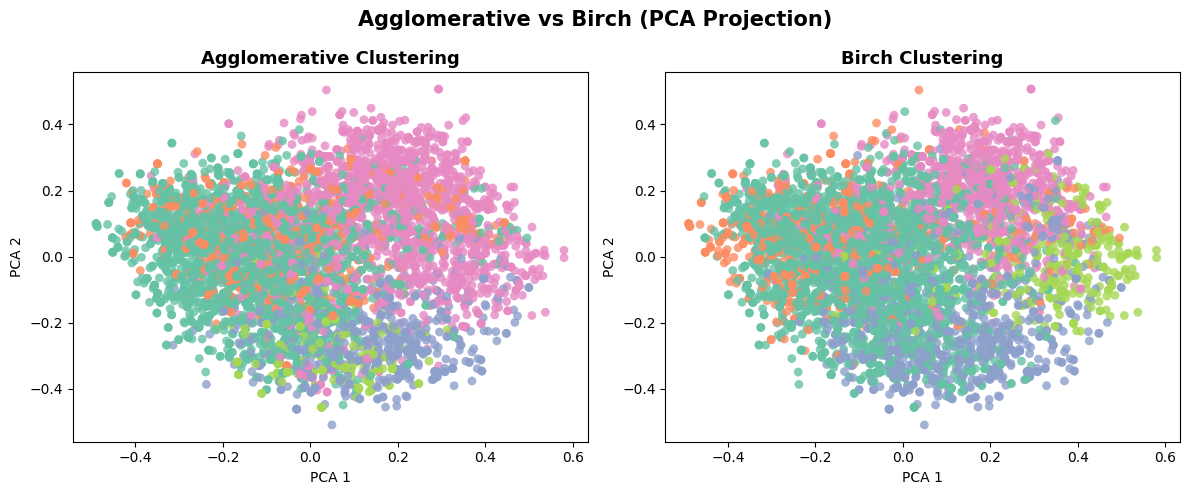

In [ ]:
# Visualize Hierarchical clustering
plt.figure(figsize=(12,5))

# Fit the models and get the labels
agglomerative_labels = agglomerative.fit_predict(X)
birch_labels = birch.fit_predict(X)

plt.subplot(1,2,1)
sns.scatterplot(x=X_vis[:,0], y=X_vis[:,1], hue=agglomerative_labels, palette='Set2', s=40, alpha=0.8, edgecolor='none')
plt.title("Agglomerative Clustering", fontsize=13, weight='bold')
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.legend([],[], frameon=False)

plt.subplot(1,2,2)
sns.scatterplot(x=X_vis[:,0], y=X_vis[:,1], hue=birch_labels, palette='Set2', s=40, alpha=0.8, edgecolor='none')
plt.title("Birch Clustering", fontsize=13, weight='bold')
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.legend([],[], frameon=False)

plt.suptitle("Agglomerative vs Birch (PCA Projection)", fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

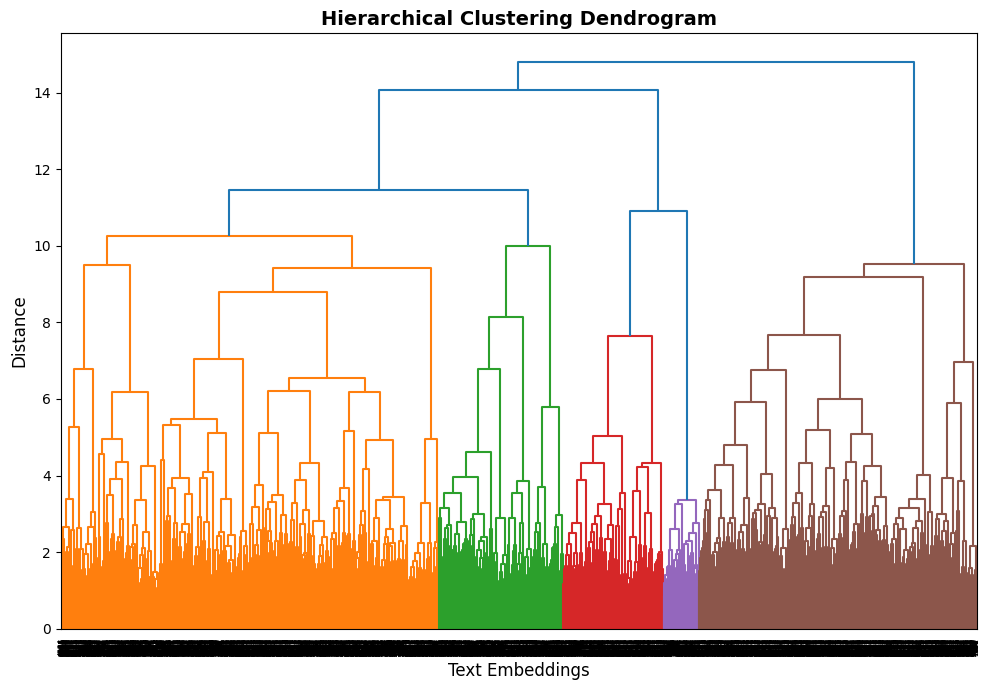

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Calculate the linkage matrix
linked = linkage(X, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram", fontsize=14, weight='bold')
plt.xlabel("Text Embeddings", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Radial plot?

/tmp/ipython-input-2439067317.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


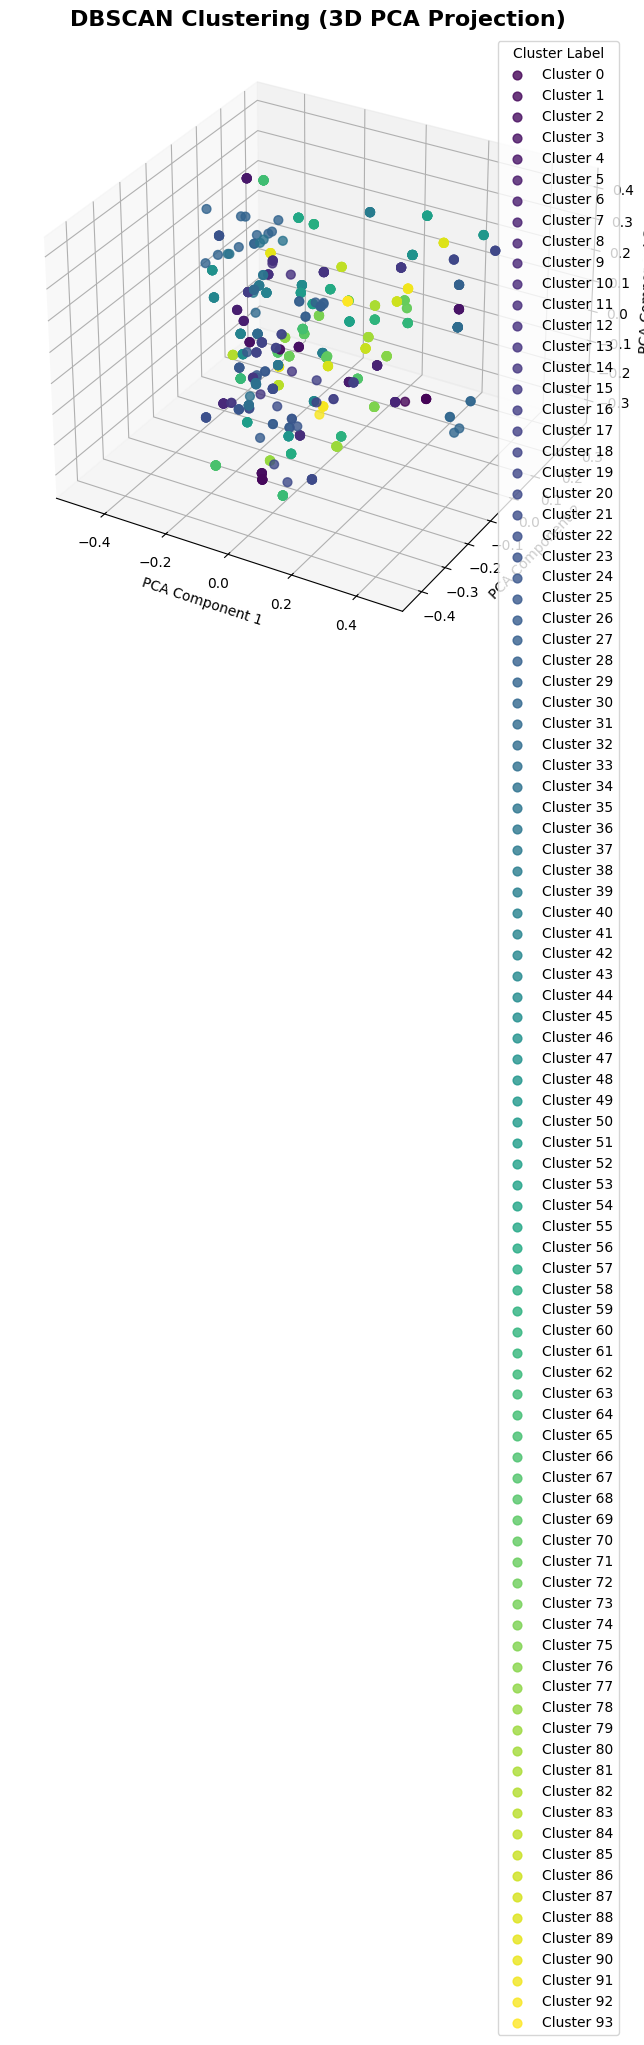

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensions to 3 for 3D visualization
pca_3d = PCA(n_components=3, random_state=42)
X_vis_3d = pca_3d.fit_transform(X)

# Fit DBSCAN
dbscan_labels_3d = dbscan.fit_predict(X)

# Visualize DBSCAN in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get unique labels excluding noise (-1)
unique_labels = np.unique(dbscan_labels_3d)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    if label != -1:
        # Plot noise points in black
        #ax.scatter(X_vis_3d[dbscan_labels_3d == label, 0],
                   #X_vis_3d[dbscan_labels_3d == label, 1],
                   #X_vis_3d[dbscan_labels_3d == label, 2],
                   #color='black', s=20, alpha=0.5, label='Noise (-1)')
    #else:
        # Plot clustered points with different colors
        ax.scatter(X_vis_3d[dbscan_labels_3d == label, 0],
                   X_vis_3d[dbscan_labels_3d == label, 1],
                   X_vis_3d[dbscan_labels_3d == label, 2],
                   color=colors[i], s=40, alpha=0.8, label=f'Cluster {label}')

ax.set_title("DBSCAN Clustering (3D PCA Projection)", fontsize=16, weight='bold')
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.legend(title="Cluster Label")

plt.tight_layout()
plt.show()

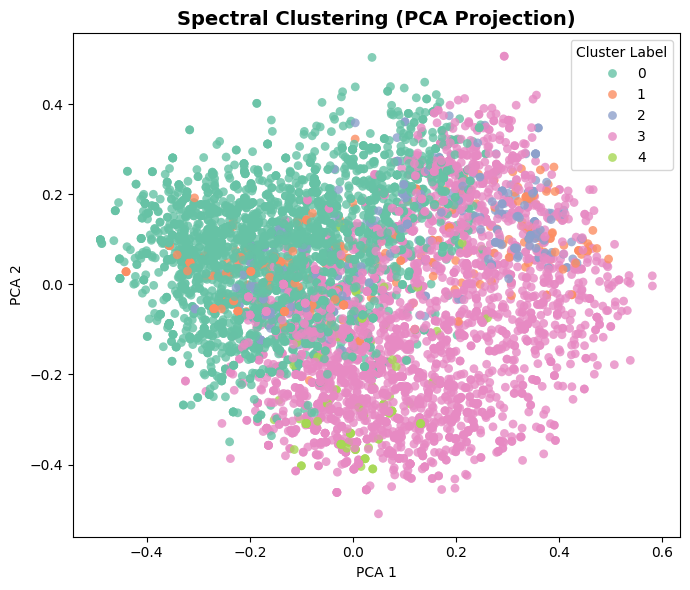

In [ ]:
# Visualize Spectral Clustering

# Fit the model and get the labels
spectral_labels = spectral.fit_predict(X)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X_vis[:,0], y=X_vis[:,1], hue=spectral_labels, palette='Set2', s=40, alpha=0.8, edgecolor='none')
plt.title("Spectral Clustering (PCA Projection)", fontsize=14, weight='bold')
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.legend(title="Cluster Label")
plt.tight_layout()
plt.show()

## Notebook Summary and Implemented Steps

This notebook aims to explore different unsupervised learning techniques for detecting political bias in text data.

**Data Loading and Preprocessing:**
- The dataset "hf://datasets/lelouch0204/cleaned_allsides_v2.csv/data/train-00000-of-00001.parquet" was loaded into a pandas DataFrame.
- The relevant columns "Text" and "Bias" were selected.
- The categorical "Bias" labels were mapped to numerical integers (0-4) for easier processing.
- The distribution of the political bias labels was visualized using a bar plot, showing an imbalance in the dataset with a higher number of "left" leaning articles.

**Text Embedding:**
- The 'all-MiniLM-L6-v2' Sentence Transformer model was used to generate embeddings for the text data, resulting in a feature matrix `X` with a shape of (6209, 384).

**Dimensionality Reduction:**
- Principal Component Analysis (PCA) was applied to reduce the dimensionality of the text embeddings from 384 to 50 components (`X_pca`). A 2-component PCA (`X_vis`) was also performed specifically for 2D visualizations.

**Unsupervised Clustering Techniques:**
- Several unsupervised clustering algorithms were initialized:
    - K-Means and Mini-Batch K-Means
    - Gaussian Mixture Model (GMM) and Bayesian Gaussian Mixture Model
    - Density-based methods: DBSCAN, HDBSCAN, OPTICS, and Mean Shift
    - Hierarchical Clustering: Agglomerative Clustering and Birch
    - Spectral Clustering
- The number of clusters for most algorithms was set to 5, matching the number of unique political bias labels.
- **Visualizations:**
    - K-Means and Mini-Batch K-Means clustering results were visualized in 2D using the 2-component PCA reduced data, showing the cluster assignments and centroids.
    - Gaussian Mixture Model (GMM) results were visualized in 2D, including the cluster means and covariance ellipses.
    - Hierarchical Clustering (Agglomerative and Birch) results were visualized in 2D.
    - A dendrogram for hierarchical clustering was generated to show the merging of clusters.
    - DBSCAN clustering results were visualized in 2D and a 3D attempt was made. The visualization differentiates between noise points and clustered points.
    - Spectral Clustering results were visualized in 2D, and the `n_neighbors` hyperparameter was adjusted.

**Evaluation Metrics:**
- A dictionary of clustering evaluation metrics was defined, including both intrinsic (Silhouette, Calinski-Harabasz, Davies-Bouldin) and extrinsic (Adjusted Rand Index, NMI, Homogeneity, Completeness, V-Measure) metrics.
- These metrics were computed for the labels obtained from fitting the various clustering algorithms.
- The computed metrics were stored in a pandas DataFrame and normalized for easier comparison.

**Current Status:**
- Several unsupervised clustering models have been fitted and their results visualized in 2D (and one attempt in 3D).
- The performance metrics have been calculated and are available in the `computed_metrics` DataFrame.
- Observations have been made regarding the visualizations, and the potential impact of hyperparameters on DBSCAN and Spectral Clustering performance has been discussed.

**Next Steps (Suggested):**
- Visualize the remaining density-based clustering results (HDBSCAN, OPTICS, Mean Shift) if desired.
- Further explore hyperparameter tuning for algorithms like DBSCAN and Spectral Clustering to potentially improve clustering results.
- Analyze the `computed_metrics` DataFrame to quantitatively compare the performance of the different clustering algorithms based on the chosen metrics.
- Based on the visualizations and metric evaluations, select the most promising unsupervised learning technique for this dataset.
- Potentially move on to exploring supervised learning techniques as outlined in the initial plan.